### Overfitting: Sources of Error
#### Bias and Variance

Bias and variance are the two statistically observable sources of error in a model that we can indirectly control. 

$Bias$ is error that results in mistaken assumptions in the model. This can take the form of failing to incorporate relevant features in the model. This leads to underfitting.

$Variance$ is error that results from the variability of the model's predicted values. This leads to overfitting. 

#### [Bias-Variance Tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff)

<img src="http://scott.fortmann-roe.com/docs/docs/BiasVariance/biasvariance.png"></img>
From [Scott Fortmann-Roe's blog](http://scott.fortmann-roe.com/docs/BiasVariance.html) post

The bias of a model can be approximated by training a few different models of the same class (e.g. Linear Regression) on the same dataset and use different features for each, calculating error scores each time. For regression, we can use mean absolute error, mean squared error, or R-squared.

An extremely simple univariate model will underfit, whereas a highly complicated multivariate model will overfit. Depending on the problem at hand, there is an optimum level of model complexity that will yield a reliable and useful model.



In [1]:
import os
import numpy as np
% matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns


names = ['mpg','cylinders','displacement','horsepower','weight','acceleration','model year','origin','car name']
data = "Data\\cars\\auto-mpg.data.txt"
cars = pd.read_table(os.path.relpath(data),delim_whitespace=True, names=names)
cleaned_cars = cars[cars['horsepower']!='?']
float_hp = cleaned_cars['horsepower'].astype(float)
cleaned_cars['horsepower'] = float_hp

filtered_cars = cleaned_cars
filtered_cars.head()


C:\Users\v-haharv\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [2]:
'''
train_and_test(cols : list) -> tuple(mse, variance)

Create function to train models and make predictions on the same input 

''' 

def train_and_test(cols):
    lr = LinearRegression()
    features = filtered_cars[cols].values
    target = filtered_cars['mpg'].values
    lr.fit(features, target)
    predictions = lr.predict(features)
    mse = mean_squared_error(target, predictions)
    variance = np.var(predictions)
    
    return(mse, variance)


weight_mse, weight_var = train_and_test(['weight'])

cyl_mse, cyl_var = train_and_test(['cylinders'])

print('MSE Cylinders: {}'.format(cyl_mse))
print('Cylinders variance: {}'.format(cyl_var))
print('MSE weight: {}'.format(weight_mse))
print('Weight variance: {}'.format(weight_var))
    
    
    

MSE Cylinders: 24.02017956815553
Cylinders variance: 36.74255887416017
MSE weight: 18.6766165974193
Weight variance: 42.08612184489641


In [13]:
cars_cols = list(filtered_cars.columns.values)
cars_cols.pop(cars_cols.index('car name'))
cars_cols.pop(cars_cols.index('mpg'))
print(cars_cols)


['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']


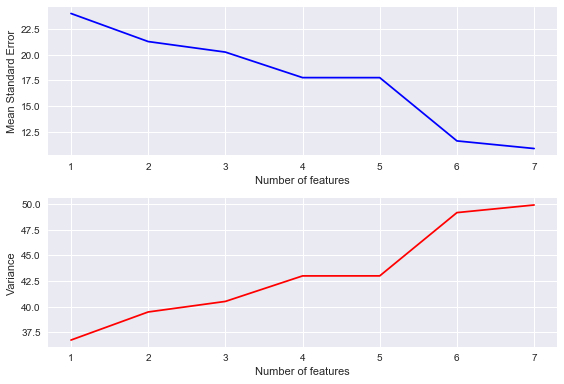

In [14]:
num_features = []
mean_standard_errors = []
variances = []
predicted_vals = {}

for i in range(len(cars_cols)):
    i += 1
    lr = LinearRegression()
    cols = cars_cols[0:i]
    features = filtered_cars[cols].values
    target = filtered_cars['mpg'].values
    lr.fit(features, target)
    predictions = lr.predict(features)
    mse = mean_squared_error(target, predictions)
    variance = np.var(predictions)
    num_features.append(i)
    mean_standard_errors.append(mse)
    variances.append(variance)
    predicted_vals[i] = predictions
    
colors = ['r','b','g','c','m','y']

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)


ax1.plot(num_features, mean_standard_errors, c='b')
ax2.plot(num_features, variances, c='r')

ax1.set(ylabel='Mean Standard Error', xlabel='Number of features')
ax2.set(ylabel = 'Variance', xlabel='Number of features')
fig.tight_layout()
plt.show()




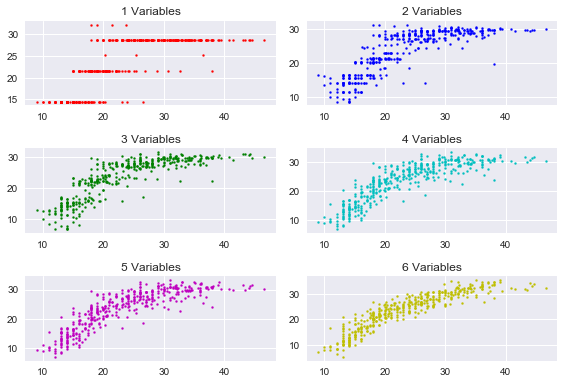

In [15]:
fig2, axes = plt.subplots(nrows = 3, ncols =2)

first_col = 0
second_col = 0
plotted = 0


for i in range(1,7):
    if i%2 != 0:
        axes[first_col,0].scatter(filtered_cars.mpg, predicted_vals[i], c = colors[i-1], s=4)
        axes[first_col,0].set(title = "{} Variables".format(i))
        first_col += 1
    else:
        axes[second_col,1 ].scatter(filtered_cars.mpg, predicted_vals[i], c = colors[i-1], s=4)
        axes[second_col,1 ].set(title = "{} Variables".format(i))
        second_col += 1
fig2.tight_layout()
plt.show()

#### Wut just happened

So we selected the features to use in the model arbitrarily with the intention of just showing the effect that the # of features has on the variance and mean standard error respectively. 

You can see that the MSE decreases as the number of features increases, while the variance increases. 

I imagine this is because as we add more variables to the model, rather than the linear model <i>predicting</i> $\hat{y}$, it's doing something more like guessing the row. The more dimensions that we add, the more it's able to approximate the structure of our data rather than the phenomenon that we're trying to predict. Just a thought there....

So now we need to figure out a way to detect if the model is overfitting to our training data. 

A real good way of doing this is to...yes...that's right...do cross validation. 
This allows us to distinguish ***in-sample error*** from ***out-of-sample error***. Basically comparing the error from the stuff that the model looked at to the error from applying the model to stuff it hasn't looked at. 


In [18]:

# import KFold validation class
from sklearn.cross_validation import KFold

def train_and_cross_val(cols):
    
    features = filtered_cars[cols]
    target = filtered_cars['mpg']
    
    # Instantiate KFold class
    kf = KFold(n=filtered_cars.shape[0], n_folds = 10, shuffle=True, random_state = 3)
    variance_results = []
    mse_results = []
    
    
    for train_index, test_index in kf:
        x_train, x_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        
        lr = LinearRegression()
        lr.fit(x_train, y_train)
        predictions = lr.predict(x_test)
        
        mse = mean_squared_error(y_test, predictions)
        var = np.var(predictions)
        
        variance_results.append(var)
        mse_results.append(mse)
    avg_mse = np.mean(mse_results)
    avg_var = np.mean(variance_results)
    
    return(avg_mse, avg_var)

In [19]:
cross_val_results = {}

# Iterate through columns and 
for i in range(len(cars_cols)):
    i += 1
    cols = cars_cols[0:i]
    avg_mse, avg_var = train_and_cross_val(cols)
    bias = dict(Avg_mse = avg_mse, Avg_var = avg_var, features=cols)
    cross_val_results[i] = bias

import pprint
pprint.pprint(cross_val_results)
    

{1: {'Avg_mse': 24.271251604850704,
     'Avg_var': 35.99007106231538,
     'features': ['cylinders']},
 2: {'Avg_mse': 21.584370274954374,
     'Avg_var': 38.902525313756016,
     'features': ['cylinders', 'displacement']},
 3: {'Avg_mse': 20.655622193882955,
     'Avg_var': 40.091287956606941,
     'features': ['cylinders', 'displacement', 'horsepower']},
 4: {'Avg_mse': 18.169683239081888,
     'Avg_var': 42.507643643644386,
     'features': ['cylinders', 'displacement', 'horsepower', 'weight']},
 5: {'Avg_mse': 18.283038517172052,
     'Avg_var': 42.598736300146825,
     'features': ['cylinders',
                  'displacement',
                  'horsepower',
                  'weight',
                  'acceleration']},
 6: {'Avg_mse': 12.099685425467117,
     'Avg_var': 48.928246967718017,
     'features': ['cylinders',
                  'displacement',
                  'horsepower',
                  'weight',
                  'acceleration',
                  'model year']

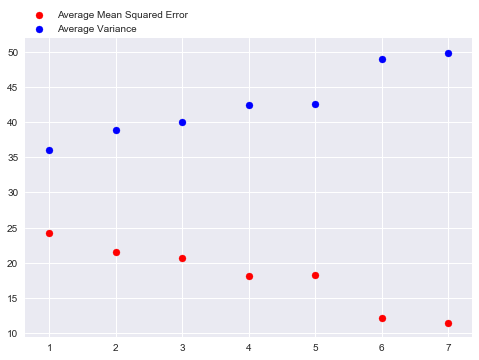

In [32]:
# Ok let's plot the results.

fig3, ax = plt.subplots()

ax.scatter([i for i in cross_val_results.keys()], [cross_val_results[i]['Avg_mse'] for i in cross_val_results.keys()], c='r', label = 'Average Mean Squared Error')
ax.scatter([i for i in cross_val_results.keys()], [cross_val_results[i]['Avg_var'] for i in cross_val_results.keys()], c='b', label = 'Average Variance')
plt.legend(bbox_to_anchor=(0,1), loc=3, borderaxespad=0)
plt.show()


#### So what's the deal? 

So we can see that the Average MSE decreases and the variance increases as the model complexity increases. 

Increasing the order of the multivariate model will make the model more sensitive to variations in the parameter values. This is why it is  important to maintain holdout data that we can use to test the accuracy of the model. 

